# <center> **THE BATTLE OF NEIGHBORHOODS** </center>

#### Author: Jinnajate Achalapong

# Introduction:

New York City's demographics show that it is a large and ethnically diverse metropolis. With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese, Thai, Indian, French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great Thai resturants.

# Data:

For this project we need the following data:
1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
2. Thai resturants in each neighborhood of new york city.
3. GeoSpace data

## Questions that will be answers at the end of this project :

### 1. What are best location in New York City for Thai Cuisine?
### 2. Which areas have potential Thai Restaurant Market?
### 3. Which all areas lack Thai Restaurants?
### 4. Which is the best place to stay if you prefer Thai Cuisine?

# Methodology:

1. We begin by collecting the New York city data from "https://cocl.us/new_york_dataset".
2. We will find all venues for each neighborhood using FourSquare API.
3. We will then filter out all Thai Restuarant venues.
4. Next using FourSquare API, we will find the Ratings, Tips, and Like count for all the Thai Resturants.
5. Next we will sort the data keeping Ratings as the constraint.
6. Finally, we will visualize the Ranking of neighborhoods using python's Folium library.

Lets Start by importing the required Libraries.

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

     |████████████████████████████████| 102kB 7.0MB/s 
Libraries imported.


Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [4]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = "AIFDBMJ5WQKT3DQSPA3ONC3SI5MRSR5U131ZCWMKB4U1XSI4" # Foursquare ID
    CLIENT_SECRET = "XODRBQPF0BRBI4A24CMR0D5THBTQTIIMY5XICASWSNAFA3CM" # Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we will define a function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.

In [5]:
def get_venue_details(venue_id):
        
    CLIENT_ID = "AIFDBMJ5WQKT3DQSPA3ONC3SI5MRSR5U131ZCWMKB4U1XSI4" # your Foursquare ID
    CLIENT_SECRET = "XODRBQPF0BRBI4A24CMR0D5THBTQTIIMY5XICASWSNAFA3CM" # your Foursquare Secret
    VERSION = '20200401' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [6]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [7]:
new_york_data=get_new_york_data()

In [8]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

### The above result shows that there are 306 different Neighborhoods in New York.

Now let create a BAR PLOT to show different Neighborhoods in New York.

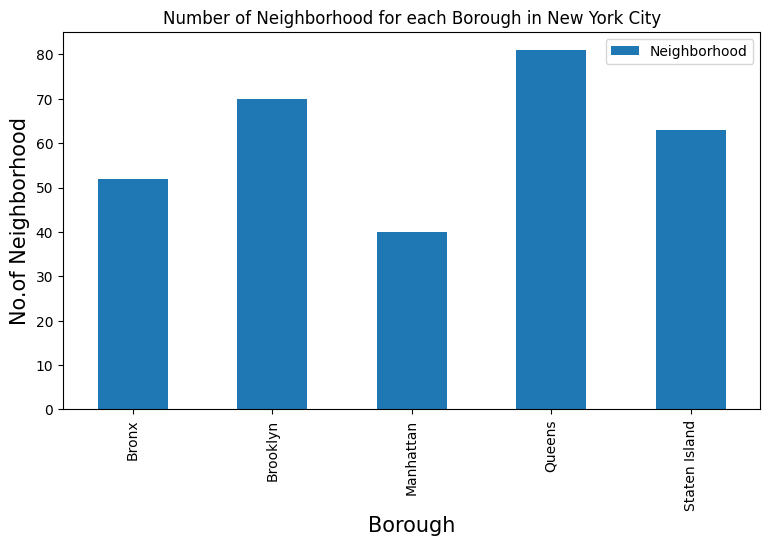

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Queens has highest number of neighborhoods.

Next we will collect Thai resturants for each Neighborhood.

In [12]:
# prepare neighborhood list that contains Thai resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
thai_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    thai_resturants=venues[venues['Category']=='Thai Restaurant']   
    print('(',count,'/',len(new_york_data),')','Thai Resturants in '+Neighborhood+', '+Borough+':'+str(len(thai_resturants)))
    for resturant_detail in thai_resturants.values.tolist():
        id, name , category=resturant_detail
        thai_rest_ny = thai_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Thai Resturants in Wakefield, Bronx:0
( 2 / 306 ) Thai Resturants in Co-op City, Bronx:0
( 3 / 306 ) Thai Resturants in Eastchester, Bronx:0
( 4 / 306 ) Thai Resturants in Fieldston, Bronx:0
( 5 / 306 ) Thai Resturants in Riverdale, Bronx:0
( 6 / 306 ) Thai Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Thai Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) Thai Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Thai Resturants in Norwood, Bronx:0
( 10 / 306 ) Thai Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Thai Resturants in Baychester, Bronx:0
( 12 / 306 ) Thai Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Thai Resturants in City Island, Bronx:0
( 14 / 306 ) Thai Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Thai Resturants in University Heights, Bronx:0
( 16 / 306 ) Thai Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Thai Resturants in Fordham, Bronx:0
( 18 / 306 ) Thai Resturants in East Tremont, Bronx:0
( 19 / 306 ) Thai Resturants in West Farms, Bronx:0


Now that we have got all the Thai resturants in new york city , we will analyze it.

In [13]:
thai_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square
1,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion
2,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine
3,Bronx,Van Nest,5585c948498e0bd8a8a706f1,Thai Cuisine
4,Bronx,Spuyten Duyvil,4a739e29f964a520f5dc1fe3,Siam Square


In [14]:
thai_rest_ny.shape

(121, 4)

### From the above result, we see that there are 121 Thai Resturants across New York City.

Now let create a BAR PLOT to show Number of Thai Resturants for each Borough in New York City.

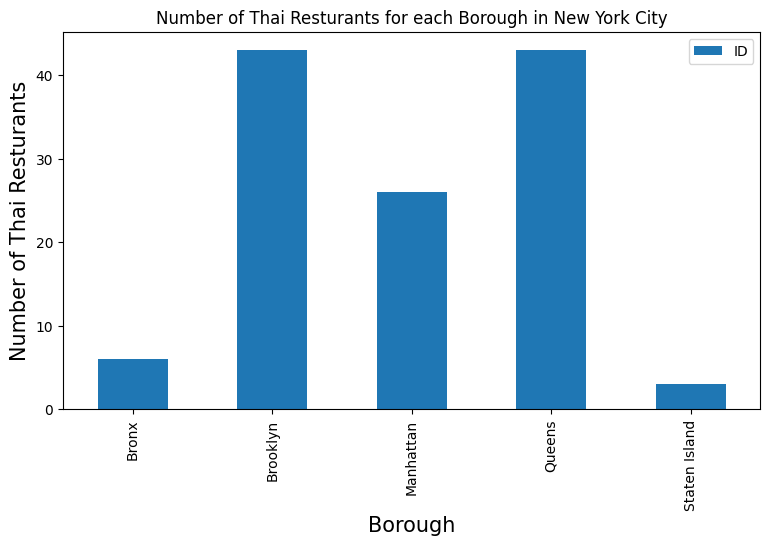

In [16]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Thai Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Number of Thai Resturants', fontsize=15)
#giving a bar plot
thai_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

### From the above Bar Plot, we can see that Brooklyn and Queens has highest number of Thai resturants.

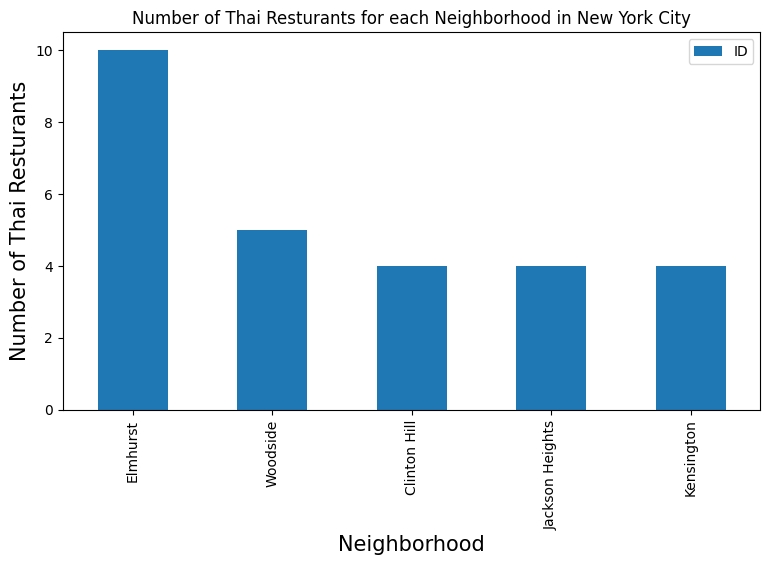

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Thai Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('Number of Thai Resturants', fontsize=15)
#giving a bar plot
thai_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [18]:
thai_rest_ny[thai_rest_ny['Neighborhood']=='Elmhurst']

,Borough,Neighborhood,ID,Name
78,Queens,Elmhurst,5abad6379de23b5eeb077b04,Lamoon
79,Queens,Elmhurst,52f693e6498ed9d2a3fbad75,Eim Khao Mun Kai Elmhurst อิ่ม ข้าวมันไก่เอ็มเ...
80,Queens,Elmhurst,593f6541123a19687791b390,Hug Esan NYC
81,Queens,Elmhurst,4b26f895f964a5209d8324e3,Ayada Thai
82,Queens,Elmhurst,4c2e801d3ffc952130568ff5,Boon Chu Thai Restaurant
83,Queens,Elmhurst,531372e9498ebd3be2888afc,Khao Kang ข้าวแกง
84,Queens,Elmhurst,4ad15d63f964a5203ede20e3,Spicy Shallot
85,Queens,Elmhurst,56e210f7cd102122a9fb1d1b,Dek Sen
86,Queens,Elmhurst,53af884e498e0a4a4943f670,Kitchen 79
87,Queens,Elmhurst,4a7b6d8ff964a520fcea1fe3,Arunee Thai


### We can see that, Elmhurst in Queens has the highest number of Thai Resturants with a total count of 10.

Now we will get the ranking of each resturant for further analysis.

In [ ]:
# prepare neighborhood list that contains thai resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
thai_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in thai_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        # recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(thai_rest_ny),')','processed')
    thai_rest_stats_ny = thai_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

In [20]:
thai_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,15,7.0,13
1,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.5,27
2,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,17,6.9,1
3,Bronx,Van Nest,5585c948498e0bd8a8a706f1,Thai Cuisine,17,6.9,1
4,Bronx,Spuyten Duyvil,4a739e29f964a520f5dc1fe3,Siam Square,15,7.0,13


In [21]:
thai_rest_stats_ny.shape

(50, 7)

In [22]:
thai_rest_ny.shape

(121, 4)

Now that we got data for all resturants Now lets save this data to a csv sheet. In case we by mistake modify it. As the number of calls to get details for venue are premium call and have limit of 500 per day, we will refer to saved data sheet csv if required.

In [23]:
thai_rest_stats_ny.to_csv('thai_rest_stats_ny.csv', index=False)

Lets verify the data from saved csv file.

In [25]:
thai_rest_stats_ny_csv=pd.read_csv('thai_rest_stats_ny.csv')

In [26]:
thai_rest_stats_ny_csv.shape

(50, 7)

In [27]:
thai_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,15,7.0,13
1,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.5,27
2,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,17,6.9,1
3,Bronx,Van Nest,5585c948498e0bd8a8a706f1,Thai Cuisine,17,6.9,1
4,Bronx,Spuyten Duyvil,4a739e29f964a520f5dc1fe3,Siam Square,15,7.0,13


In [28]:
thai_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


The Data type of 'Likes' and  'Tips' are of type 'String'. we will convert them into type 'Float' for further analysis.

In [29]:
thai_rest_stats_ny['Likes']=thai_rest_stats_ny['Likes'].astype('float64')
thai_rest_stats_ny['Tips']=thai_rest_stats_ny['Tips'].astype('float64')

In [30]:
thai_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


Now we will find the Thai restuarants with Maximum Likes, Maximum Ratings and Maximum Tips.

In [31]:
# Resturant with maximum Likes
thai_rest_stats_ny.iloc[thai_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood           East Williamsburg
ID              4fc01ea6e4b0e4e80c70cf1d
Name                       Sage Brooklyn
Likes                                514
Rating                               8.3
Tips                                 124
Name: 44, dtype: object

In [32]:
# Resturant with maximum Rating
thai_rest_stats_ny.iloc[thai_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                   Chinatown
ID              5cc4e9d0c876c8002c3010cb
Name                               Wayla
Likes                                 54
Rating                               9.3
Tips                                  32
Name: 47, dtype: object

In [33]:
# Resturant with maximum Tips
thai_rest_stats_ny.iloc[thai_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Cobble Hill
ID              4112ca00f964a520ed0b1fe3
Name                                Joya
Likes                                318
Rating                               7.7
Tips                                 158
Name: 23, dtype: object

Next lets visualize neighborhood with maximum average rating of resturants.

In [34]:
ny_neighborhood_stats=thai_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [35]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
5,Chinatown,9.25
24,Prospect Lefferts Gardens,9.00
9,Crown Heights,8.70
10,Downtown,8.60
1,Boerum Hill,8.60
26,Red Hook,8.40
3,Bushwick,8.40
4,Carroll Gardens,8.30
12,East Williamsburg,8.30
16,Gowanus,8.30


### Above are the top neighborhoods with top average rating of Thai resturants.

Similarly we will find the average rating of Thai Resturants for each Borough.

In [36]:
ny_borough_stats=thai_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [37]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.125000
1,Brooklyn,8.002500
0,Bronx,5.966667


Lets Visualize it.

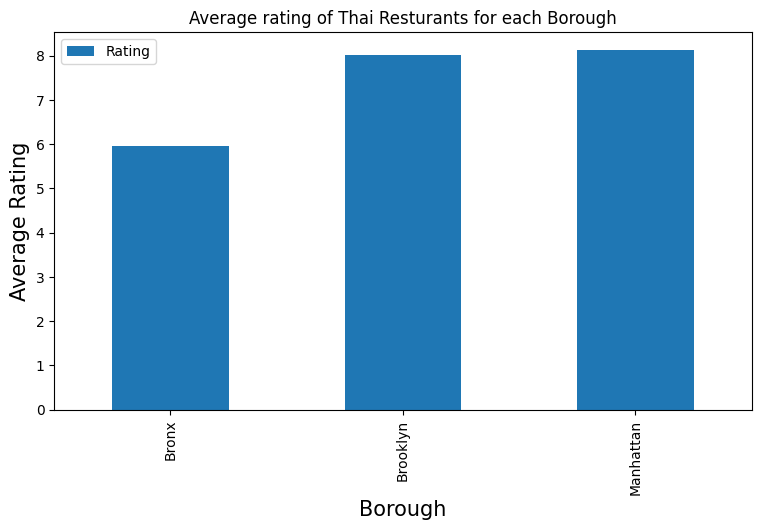

In [38]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Thai Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
thai_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 9.0 to visualize on map.

In [39]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [40]:
ny_neighborhood_stats

,Neighborhood,Average Rating
5,Chinatown,9.25
24,Prospect Lefferts Gardens,9.00


We will join this dataset to original new york data to get lonitude and latitude.

In [41]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [42]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [43]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chinatown,40.715618,-73.994279,9.25
1,Brooklyn,Prospect Lefferts Gardens,40.658420,-73.954899,9.00


Finally, Let's show this data on a map.

In [44]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [45]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose.

In [46]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [47]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods.
Lets Visualize Boroughs based on average Rating.

In [ ]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough_Boundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

# Conclusion:

### So now we can answer the questions asked above in the Questions section of the notebook.
### From our anaysis the answers to the above questions are:

#### A1) Chinatown (Manhattan), Prospect Lefferts Garden (Brooklyn) are the best neighborhoods for Thai cuisine.
#### A2) Manhattan have potential Thai Resturant Market.
#### A3) Gowanus ranks last in average rating of Thai Resturants.
#### A4) Manhattan is the best place to stay if you prefer Thai Cuisine.